In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [4]:
from birdclef.utils import get_spark

spark = get_spark(memory="16g")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/22 21:32:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
df = spark.read.parquet(
    "../data/processed/birdclef-2022/birdnet-embeddings-with-neighbors/v1"
)
df.printSchema()
df.show(n=1, vertical=True)

root
 |-- id: integer (nullable = true)
 |-- filename: string (nullable = true)
 |-- start_sec: double (nullable = true)
 |-- end_sec: double (nullable = true)
 |-- confidence: double (nullable = true)
 |-- birdnet_label: string (nullable = true)
 |-- birdnet_common_name: string (nullable = true)
 |-- emb: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- primary_label: string (nullable = true)
 |-- secondary_labels: string (nullable = true)
 |-- type: string (nullable = true)
 |-- neighbors: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- distances: array (nullable = true)
 |    |-- element: double (containsNull = true)



-RECORD 0-----------------------------------
 id                  | 11876                
 filename            | belkin1/XC321817.ogg 
 start_sec           | 15.0                 
 end_sec             | 18.0                 
 confidence          | 0.1058               
 birdnet_label       | rucspa               
 birdnet_common_name | Rufous-crowned Sp... 
 emb                 | [0.54678416, 0.58... 
 primary_label       | belkin1              
 secondary_labels    | []                   
 type                | ['song']             
 neighbors           | [11877, 11876, 11... 
 distances           | [0.0, 0.0, 0.0, 4... 
only showing top 1 row



In [18]:
from pyspark.sql import functions as F, Window

exploded_neighborhood = (
    df.select(
        "id",
        F.explode(F.arrays_zip("neighbors", "distances")).alias("neighbor"),
    )
    .selectExpr(
        "id", "neighbor.neighbors as neighbor_id", "neighbor.distances as distance"
    )
    .join(df.selectExpr("id as neighbor_id", "birdnet_label"), on="neighbor_id")
)

# lets get get the p05, p50, and p95 distances for each label
distances = exploded_neighborhood.groupBy("id").agg(
    F.percentile_approx("distance", 0.05).alias("distance_p05"),
    F.percentile_approx("distance", 0.50).alias("distance_p50"),
    F.percentile_approx("distance", 0.95).alias("distance_p95"),
)

# Let's perform a k-nn classification on the neighborhood using the birdnet
# labels. We'll compute the score for each label using majority vote. In later
# iterations, we might only keep neighbors that are within a certain distance of
# the ego node.
labeled_neighborhood = (
    exploded_neighborhood
    # first add information to the neighbors so we can compute the classification
    .groupBy("id", "birdnet_label")
    # get the median distance
    .agg(F.count("*").alias("n"))
    .withColumn("total", F.sum("n").over(Window.partitionBy("id")))
    .withColumn("score", F.col("n") / F.col("total"))
    .withColumn(
        "rank", F.row_number().over(Window.partitionBy("id").orderBy(F.desc("n")))
    )
    .where("rank = 1")
    .drop("rank")
    .join(distances, on="id")
    # now let's join information back to the ego node
    .join(
        df.selectExpr(
            "id",
            "primary_label as ego_primary_label",
            "birdnet_label as ego_birdnet_label",
        ),
        on="id",
    )
)

labeled_neighborhood.show()

+---+-------------+---+-----+-----+------------------+-----------------+------------------+-----------------+-----------------+
| id|birdnet_label|  n|total|score|      distance_p05|     distance_p50|      distance_p95|ego_primary_label|ego_birdnet_label|
+---+-------------+---+-----+-----+------------------+-----------------+------------------+-----------------+-----------------+
| 26|      afrsil1|  6|   50| 0.12| 6.060283660888672|  6.9895339012146| 7.148179531097412|          afrsil1|           indsil|
| 27|      afrsil1|  6|   50| 0.12| 6.060283660888672|  6.9895339012146| 7.148179531097412|          afrsil1|          afrsil1|
| 28|       skylar|  7|   50| 0.14|4.5320820808410645|4.881272792816162|5.0357441902160645|          afrsil1|          orisky1|
| 31|       houfin|  8|   50| 0.16| 4.992083549499512|7.063246250152588| 7.614339828491211|          afrsil1|          afpfly1|
| 34|      afrsil1|  9|   50| 0.18|4.6025238037109375|7.147627830505371| 7.436990261077881|          afr

In [21]:
agreement = (
    labeled_neighborhood.withColumn(
        "ego_birdnet_label_matches",
        (F.col("ego_primary_label") == F.col("ego_birdnet_label")).astype("int"),
    )
    .withColumn(
        "knn_birdnet_label_matches",
        (F.col("ego_primary_label") == F.col("birdnet_label")).astype("int"),
    )
    .groupBy("ego_primary_label")
    .agg(
        F.count("*").alias("n"),
        F.sum("ego_birdnet_label_matches").alias("n_ego_birdnet_label_matches"),
        F.sum("knn_birdnet_label_matches").alias("n_knn_birdnet_label_matches"),
    )
    .withColumn(
        "pct_ego_birdnet_label_matches",
        F.col("n_ego_birdnet_label_matches") / F.col("n"),
    )
    .withColumn(
        "pct_knn_birdnet_label_matches",
        F.col("n_knn_birdnet_label_matches") / F.col("n"),
    )
    .orderBy(F.desc("n"))
)
agreement.show()

+-----------------+-----+---------------------------+---------------------------+-----------------------------+-----------------------------+
|ego_primary_label|    n|n_ego_birdnet_label_matches|n_knn_birdnet_label_matches|pct_ego_birdnet_label_matches|pct_knn_birdnet_label_matches|
+-----------------+-----+---------------------------+---------------------------+-----------------------------+-----------------------------+
|           normoc|25068|                       5742|                      13414|          0.22905696505505027|            0.535104515717249|
|           houspa|18173|                       8683|                      15517|          0.47779673141473616|           0.8538491168216585|
|           skylar|12849|                       6816|                      11874|           0.5304692972215737|           0.9241186084520197|
|           norcar|12216|                       4520|                       7989|           0.3700065487884741|           0.6539783889980354|
|     

Now that we've computed a k-nn classifier, we can build a few statistics for our visualization.
We're going to make a plot with the embedding for a single species, and show the ego birdnet label performance vs the k-nn birdnet labels.


In [19]:
freq_primary_labels = (
    df.groupBy("primary_label").agg(F.count("*").alias("n")).orderBy(F.desc("n"))
).toPandas()

freq_primary_labels.head()

,primary_label,n
0,normoc,25068
1,houspa,18173
2,skylar,12849
3,norcar,12216
4,wesmea,9479


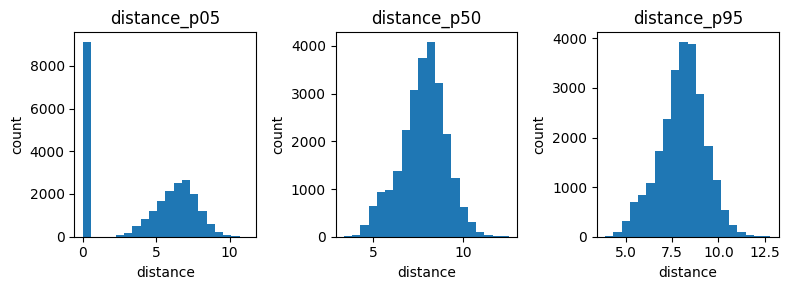

UMAP( verbose=True)
Sun Jan 22 23:03:52 2023 Construct fuzzy simplicial set
Sun Jan 22 23:03:52 2023 Finding Nearest Neighbors
Sun Jan 22 23:03:52 2023 Building RP forest with 13 trees
Sun Jan 22 23:03:52 2023 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	 7  /  15
	Stopping threshold met -- exiting after 7 iterations
Sun Jan 22 23:03:53 2023 Finished Nearest Neighbor Search
Sun Jan 22 23:03:54 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:12]


Sun Jan 22 23:04:08 2023 Finished embedding


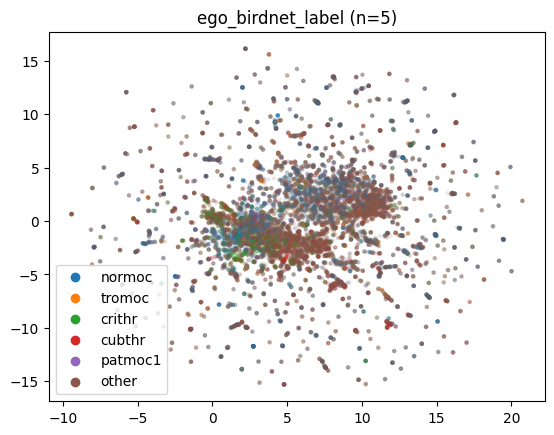

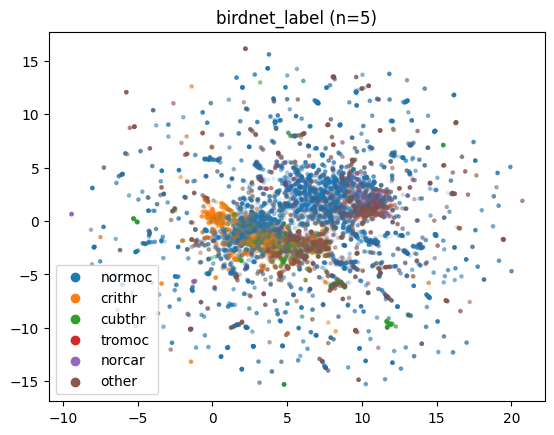

In [68]:
# let's plot the distribution of distances for the p05, p50, and p95
import matplotlib.pyplot as plt
import numpy as np
from umap import UMAP


def get_subset_pdf(df, labeled_neighborhood, rank):
    freq_primary_labels = (
        df.groupBy("primary_label").agg(F.count("*").alias("n")).orderBy(F.desc("n"))
    ).toPandas()
    primary_label = freq_primary_labels.iloc[rank].primary_label
    subset = labeled_neighborhood.where(
        F.col("ego_primary_label") == primary_label
    ).join(df.select("id", "emb"), on="id")
    return subset.toPandas()


def plot_distances(pdf):
    fig, axes = plt.subplots(1, 3, figsize=(8, 3))
    ax = axes.flatten()
    for i, col in enumerate(["distance_p05", "distance_p50", "distance_p95"]):
        pdf[col].plot.hist(ax=ax[i], title=col, bins=20)
        ax[i].set_xlabel("distance")
        ax[i].set_ylabel("count")
    plt.tight_layout()
    plt.show()


def compute_embedding_2d(pdf, **kwargs):
    X = np.stack(pdf.emb.values)
    return UMAP(n_components=2, **kwargs).fit_transform(X)


# keep the 5 most common labels
def plot_embedding(pdf, emb, label_col, n_labels, **kwargs):
    top_labels = (
        pdf.groupby(label_col).size().sort_values(ascending=False).head(n_labels).index
    ).tolist()
    labels = [x if x in top_labels else "other" for x in pdf[label_col].tolist()]
    # now create a color map
    cmap = {label: f"C{i}" for i, label in enumerate(top_labels + ["other"])}
    colors = [cmap[x] for x in labels]

    plt.scatter(emb[:, 0], emb[:, 1], s=5, c=colors, alpha=0.1)

    for label, color in cmap.items():
        plt.scatter([], [], c=color, label=label)
    plt.legend()
    plt.title(f"{label_col} (n={n_labels})")
    plt.show()


# plot distances from the ego node to its neighbors
pdf = get_subset_pdf(df, labeled_neighborhood, 0)
plot_distances(pdf)
emb = compute_embedding_2d(pdf, verbose=True)
plot_embedding(pdf, emb, "ego_birdnet_label", 5)
plot_embedding(pdf, emb, "birdnet_label", 5)

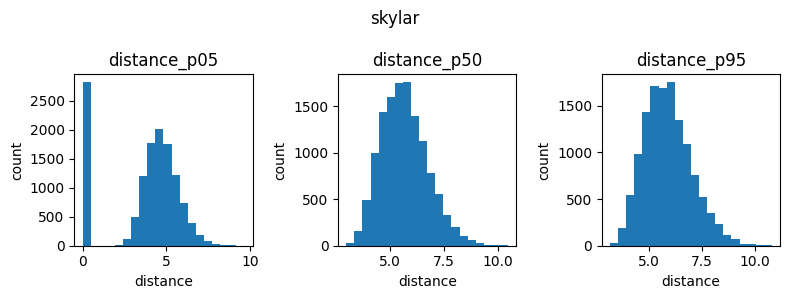

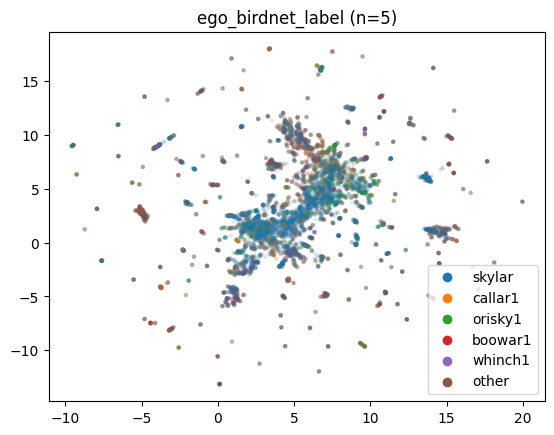

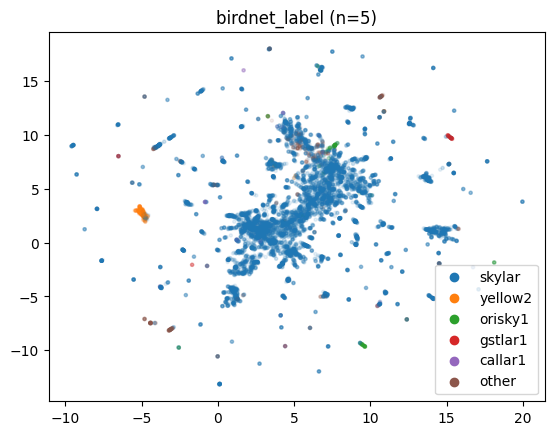

In [66]:
pdf = get_subset_pdf(df, labeled_neighborhood, 1)
plot_distances(pdf)
emb = compute_embedding_2d(pdf)
plot_embedding(pdf, emb, "ego_birdnet_label", 5)
plot_embedding(pdf, emb, "birdnet_label", 5)